<a href="https://colab.research.google.com/github/JulianaDamurie/AprendizagemDeMaquina/blob/main/lvq_knn_jnds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import
import time
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import KFold, StratifiedKFold
import math
import scipy
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
from past.builtins import xrange
from collections import OrderedDict
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
class KNN:
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

        self.rAKNN = self.adaptive(X,y)
        
    def distance(self, X1, X2):
        distance = scipy.spatial.distance.euclidean(X1, X2)
        return distance

    def adaptive(self,X1,X2):
      d_a = {}
      len_data = X1.shape[0]
      epsilon = 0.0001

      all_distances = scipy.spatial.distance.cdist(X1, X1, 'euclidean')

      for i in range(len_data):
        r_max = math.inf
        for j in range(len_data):
          if X2[i] != X2[j]:
            r = all_distances[i][j] 
            if r < r_max:
              r_max = r 
        d_a[i] = (r_max - epsilon)
      return d_a
    
    def predict(self, X_test):
        final_output = []
        distances =  scipy.spatial.distance.cdist( self.X_train , X_test, 'euclidean')

        for i in range(len(X_test)):
            d = []
            votes = []
            for j in range(len(self.X_train)):
                dist = np.absolute(distances[j][i] / self.rAKNN[j])
                d.append([dist, j])
            d.sort()
            d = d[0:self.k]
            for d, j in d:
                votes.append(self.y_train[j])
            ans = Counter(votes).most_common(1)[0][0]
            final_output.append(ans)
            
        return final_output
    
    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        return (predictions == y_test).sum() / len(y_test)

In [ ]:
class LVQ1:
  def __init__(self, n):
    self.n = n

  def selection(self, X, Y):
      self.X = X
      self.Y = Y

      len_class_one = np.count_nonzero(Y == "false")
      len_class_two = np.count_nonzero(Y == "true")

      n_one = int((len_class_one/len(X))*self.n)
      n_two = self.n-n_one

  
      rus = RandomUnderSampler(return_indices=True)
      X_rus, y_rus, id_rus = rus.fit_sample(X, Y)

      X_class_one = X_rus[0:int(n_one)]
      X_class_two = X_rus[len(X_rus)-int(n_two):len(X_rus)]

      Y_class_one = y_rus[0:int(n_one)]
      Y_class_two = y_rus[len(X_rus)-int(n_two):len(X_rus)]

      self.X_p = np.concatenate((X_class_one,X_class_two),axis=0)
      self.Y_p = np.concatenate((Y_class_one,Y_class_two),axis=0)

  def fit(self,alpha,interactions):
    classifier = KNeighborsClassifier(n_neighbors = 1,weights="uniform") 
    for j in range(interactions):
      for i in range(len(self.X)): 
        classifier.fit(self.X_p, self.Y_p) 
        ordered_prots = classifier.kneighbors(self.X[i].reshape(1, -1) , return_distance=True,n_neighbors=self.n)
        dist_winner = ordered_prots[0][0][0]
        index_winner = ordered_prots[1][0][0]

        class_p = self.Y_p[index_winner]
        class_x = self.Y[i]

        if(class_p == class_x): 
          self.X_p[index_winner] = self.X_p[index_winner] + (alpha*(self.X[i]-self.X_p[index_winner]))
        else:
          self.X_p[index_winner] = self.X_p[index_winner] - (alpha*(self.X[i]-self.X_p[index_winner]))
        
    return self.X_p,self.Y_p
      

In [ ]:
class LVQ21:
  def __init__(self, n):
    self.n = n

  def selection(self, X, Y):
      self.X = X
      self.Y = Y

      len_class_one = np.count_nonzero(Y == "false")
      len_class_two = np.count_nonzero(Y == "true")

      n_one = int((len_class_one/len(X))*self.n)
      n_two = self.n-n_one

      res_list_one = [i for i, value in enumerate(Y) if value == "false"]
      res_list_two = [i for i, value in enumerate(Y) if value == "true"]

      res_list_one = np.random.shuffle(res_list_one)
      res_list_two = np.random.shuffle(res_list_two)

      X_class_one = X[res_list_one][0]
      X_class_two = X[res_list_two][0]

      X_class_one = X_class_one[0:int(n_one)]
      X_class_two = X_class_two[len(X_class_two)-int(n_two):len(X_class_two)]

      Y_class_one = Y[res_list_one][0]
      Y_class_two = Y[res_list_two][0]

      Y_class_one = Y_class_one[0:int(n_one)]
      Y_class_two = Y_class_two[len(Y_class_two)-int(n_two):len(Y_class_two)]

      self.X_p = np.concatenate((X_class_one,X_class_two),axis=0)
      self.Y_p = np.concatenate((Y_class_one,Y_class_two),axis=0)

  def fit(self,alpha,w,interactions):
    classifier = KNeighborsClassifier(n_neighbors = 2,weights="uniform") 
    for j in range(interactions):
      for i in range(len(self.X)): 
        classifier.fit(self.X_p, self.Y_p) 
        ordered_prots = classifier.kneighbors(self.X[i].reshape(1, -1) , return_distance=True,n_neighbors=self.n)
        dist_winner = ordered_prots[0][0][0]
        index_winner = ordered_prots[1][0][0]

        dist_second = ordered_prots[0][0][1]
        index_second = ordered_prots[1][0][1]

        class_pi = self.Y_p[index_winner]
        class_pj = self.Y_p[index_second]
        class_x = self.Y[i]

        if(self.janela(dist_winner,dist_second,w)):
          if(class_pi != class_pj):
            if(class_pi == class_x):
              self.X_p[index_winner] = self.X_p[index_winner] + (alpha*(self.X[i]-self.X_p[index_winner]))
              self.X_p[index_second] = self.X_p[index_second] - (alpha*(self.X[i]-self.X_p[index_second]))
            else:
              self.X_p[index_winner] = self.X_p[index_winner] - (alpha*(self.X[i]-self.X_p[index_winner]))
              self.X_p[index_second] = self.X_p[index_second] + (alpha*(self.X[i]-self.X_p[index_second]))
  
    return self.X_p,self.Y_p

  def janela(self,d_winner,d_second,w):
    s = (1-w)/(1+w)
    if(min((d_winner/(d_second+0.00000000000000001)),(d_second/(d_winner+0.00000000000000001))) > s):
      return True
    return False

In [ ]:
class LVQ3:
  def __init__(self, n):
    self.n = n

  def selection(self, X, Y):
      self.X = X
      self.Y = Y

      len_class_one = np.count_nonzero(Y == "false")
      len_class_two = np.count_nonzero(Y == "true")

      n_one = int((len_class_one/len(X))*self.n)
      n_two = self.n-n_one

      res_list_one = [i for i, value in enumerate(Y) if value == "false"]
      res_list_two = [i for i, value in enumerate(Y) if value == "true"]

      res_list_one = np.random.shuffle(res_list_one)
      res_list_two = np.random.shuffle(res_list_two)

      X_class_one = X[res_list_one][0]
      X_class_two = X[res_list_two][0]

      X_class_one = X_class_one[0:int(n_one)]
      X_class_two = X_class_two[len(X_class_two)-int(n_two):len(X_class_two)]

      Y_class_one = Y[res_list_one][0]
      Y_class_two = Y[res_list_two][0]

      Y_class_one = Y_class_one[0:int(n_one)]
      Y_class_two = Y_class_two[len(Y_class_two)-int(n_two):len(Y_class_two)]

      self.X_p = np.concatenate((X_class_one,X_class_two),axis=0)
      self.Y_p = np.concatenate((Y_class_one,Y_class_two),axis=0)

  def fit(self,alpha,w,e,interactions):
    classifier = KNeighborsClassifier(n_neighbors = 2,weights="uniform") 
    for j in range(interactions):
      for i in range(len(self.X)): 
        classifier.fit(self.X_p, self.Y_p) 
        ordered_prots = classifier.kneighbors(self.X[i].reshape(1, -1) , return_distance=True,n_neighbors=self.n)
        dist_winner = ordered_prots[0][0][0]
        index_winner = ordered_prots[1][0][0]

        dist_second = ordered_prots[0][0][1]
        index_second = ordered_prots[1][0][1]

        class_pi = self.Y_p[index_winner]
        class_pj = self.Y_p[index_second]
        class_x = self.Y[i]

        if(self.janela(dist_winner,dist_second,w)):
          if(class_pi != class_pj):
            if(class_pi == class_x):
              self.X_p[index_winner] = self.X_p[index_winner] + (alpha*(self.X[i]-self.X_p[index_winner]))
              self.X_p[index_second] = self.X_p[index_second] - (alpha*(self.X[i]-self.X_p[index_second]))
            else:
              self.X_p[index_winner] = self.X_p[index_winner] - (alpha*(self.X[i]-self.X_p[index_winner]))
              self.X_p[index_second] = self.X_p[index_second] + (alpha*(self.X[i]-self.X_p[index_second]))
          elif(class_pi == class_pj & class_pi == class_x):
            self.X_p[index_winner] = self.X_p[index_winner] + e*(alpha*(self.X[i]-self.X_p[index_winner]))
            self.X_p[index_second] = self.X_p[index_second] + e*(alpha*(self.X[i]-self.X_p[index_second]))
    return self.X_p,self.Y_p

  def janela(self,d_winner,d_second,w):
    s = (1-w)/(1+w)
    if(min((d_winner/(d_second+0.00000000000000001)),(d_second/(d_winner+0.00000000000000001))) > s):
      return True
    return False

In [ ]:

# read first data set
dataset = False

if dataset:
  data, meta = arff.loadarff('/content/jm1.arff')

  df1 = pd.DataFrame(data)

  df1["defects"] = df1["defects"].astype(str).str.replace("b","")
  df1["defects"] = df1["defects"].astype(str).str.replace("'","")
else:
  data, meta = arff.loadarff('/content/kc2.arff')

  df1 = pd.DataFrame(data)

  df1["problems"] = df1["problems"].astype(str).str.replace("b","")
  df1["problems"] = df1["problems"].astype(str).str.replace("'","")
  df1["problems"] = df1["problems"].astype(str).str.replace("yes","true")
  df1["problems"] = df1["problems"].astype(str).str.replace("no","false")

df1 = df1.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

df1

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,problems
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,1.30,1.30,2.0,2.0,2.0,2.0,1.2,1.2,1.2,1.2,1.4,false
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,true
2,415.0,59.0,50.0,51.0,1159.0,8411.31,0.01,103.53,81.24,870848.58,2.80,48380.48,359.0,35.0,9.0,10.0,47.0,106.0,692.0,467.0,106.0,true
3,230.0,33.0,10.0,16.0,575.0,3732.82,0.03,39.82,93.74,148644.06,1.24,8258.00,174.0,15.0,34.0,5.0,23.0,67.0,343.0,232.0,65.0,true
4,175.0,26.0,12.0,13.0,500.0,3123.96,0.03,29.48,105.96,92103.07,1.04,5116.84,142.0,7.0,19.0,4.0,18.0,58.0,310.0,190.0,51.0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,4.0,1.0,1.0,1.0,5.0,11.61,0.50,2.00,5.80,23.22,0.00,1.29,2.0,0.0,0.0,0.0,4.0,1.0,4.0,1.0,1.0,true
518,4.0,1.0,1.0,1.0,4.0,8.00,0.67,1.50,5.33,12.00,0.00,0.67,2.0,0.0,0.0,0.0,3.0,1.0,3.0,1.0,1.0,true
519,4.0,1.0,1.0,1.0,4.0,8.00,0.67,1.50,5.33,12.00,0.00,0.67,2.0,0.0,0.0,0.0,3.0,1.0,3.0,1.0,1.0,true
520,4.0,1.0,1.0,1.0,5.0,11.61,0.67,1.50,7.74,17.41,0.00,0.97,2.0,0.0,0.0,0.0,3.0,2.0,3.0,2.0,1.0,true


In [ ]:
# divide into x_train, y_train, x_test and y_test

x_df1 = np.array(df1.iloc[:, :-1].values)
y_df1 = np.array(df1.iloc[:, 21].values)

In [ ]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
scaler = StandardScaler()

# n é o número de protótipos 
n = 30

In [ ]:
k_list = [1,2,3,5]
dict_results_sem = {}
acc_peso = {}

lvq1 = LVQ1(n)
lvq21 = LVQ21(n)
lvq3 = LVQ3(n)
for k in k_list :
  i = 0
  sum = 0 
  recall_true = 0
  recall_false = 0
  precision_true = 0
  precision_false = 0
  tempo_init = time.time()
  for train_index, test_index in  skf.split(x_df1,y_df1):
    xdf1_train, xdf1_test = x_df1[train_index], x_df1[test_index]
    ydf1_train, ydf1_test = y_df1[train_index], y_df1[test_index]

    scaler.fit(xdf1_train)

    xdf1_train = scaler.transform(xdf1_train)

    lvq1.selection(xdf1_train,ydf1_train)
    xdf1_train,ydf1_train = lvq1.fit(0.1,100)

    xdf1_test = scaler.transform(xdf1_test) 

    classifier = KNeighborsClassifier(n_neighbors = k,weights="uniform")  
    classifier.fit(xdf1_train, ydf1_train)  
    
    tempo_treino = time.time() - tempo_init 
    tempo_init = time.time()

    ydf1_pred = classifier.predict(xdf1_test)

    #print(confusion_matrix(ydf1_test, ydf1_pred))  
    #print(classification_report(ydf1_test, ydf1_pred))
    dict_results_sem[k,i] = classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy']  

    sum += classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy'] 
    recall_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['recall']
    precision_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['precision']

    recall_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['recall']
    precision_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['precision']

    print("k------",k,i)
    print(classification_report(ydf1_test, ydf1_pred))
    i+=1
  tempo = time.time() - tempo_init 
  acc_peso[k,0] = [sum/5,k,"LVQ1 + k-NN sem peso",recall_true/5,precision_true/5,recall_false/5,precision_false/5,tempo_treino,tempo/5]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 0
              precision    recall  f1-score   support

       false       1.00      0.29      0.45        83
        true       0.27      1.00      0.43        22

    accuracy                           0.44       105
   macro avg       0.64      0.64      0.44       105
weighted avg       0.85      0.44      0.44       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 1
              precision    recall  f1-score   support

       false       0.92      0.65      0.76        83
        true       0.37      0.77      0.50        22

    accuracy                           0.68       105
   macro avg       0.64      0.71      0.63       105
weighted avg       0.80      0.68      0.71       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 2
              precision    recall  f1-score   support

       false       1.00      0.42      0.59        83
        true       0.30      1.00      0.47        21

    accuracy                           0.54       104
   macro avg       0.65      0.71      0.53       104
weighted avg       0.86      0.54      0.57       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 3
              precision    recall  f1-score   support

       false       0.92      0.57      0.70        83
        true       0.32      0.81      0.46        21

    accuracy                           0.62       104
   macro avg       0.62      0.69      0.58       104
weighted avg       0.80      0.62      0.65       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 4
              precision    recall  f1-score   support

       false       0.91      0.83      0.87        83
        true       0.50      0.67      0.57        21

    accuracy                           0.80       104
   macro avg       0.70      0.75      0.72       104
weighted avg       0.83      0.80      0.81       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 0
              precision    recall  f1-score   support

       false       0.86      0.94      0.90        83
        true       0.64      0.41      0.50        22

    accuracy                           0.83       105
   macro avg       0.75      0.67      0.70       105
weighted avg       0.81      0.83      0.81       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 1
              precision    recall  f1-score   support

       false       0.84      0.95      0.89        83
        true       0.64      0.32      0.42        22

    accuracy                           0.82       105
   macro avg       0.74      0.63      0.66       105
weighted avg       0.80      0.82      0.79       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 2
              precision    recall  f1-score   support

       false       0.84      0.92      0.88        83
        true       0.50      0.33      0.40        21

    accuracy                           0.80       104
   macro avg       0.67      0.62      0.64       104
weighted avg       0.77      0.80      0.78       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 3
              precision    recall  f1-score   support

       false       0.82      1.00      0.90        83
        true       1.00      0.14      0.25        21

    accuracy                           0.83       104
   macro avg       0.91      0.57      0.58       104
weighted avg       0.86      0.83      0.77       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 4
              precision    recall  f1-score   support

       false       0.80      1.00      0.89        83
        true       0.00      0.00      0.00        21

    accuracy                           0.80       104
   macro avg       0.40      0.50      0.44       104
weighted avg       0.64      0.80      0.71       104

k------ 3 0
              precision    recall  f1-score   support

       false       0.88      0.89      0.89        83
        true       0.57      0.55      0.56        22

    accuracy                           0.82       105
   macro avg       0.73      0.72      0.72       105
weighted avg       0.82      0.82      0.82       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 1
              precision    recall  f1-score   support

       false       0.76      0.78      0.77        83
        true       0.05      0.05      0.05        22

    accuracy                           0.63       105
   macro avg       0.40      0.41      0.41       105
weighted avg       0.61      0.63      0.62       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 2
              precision    recall  f1-score   support

       false       0.82      0.59      0.69        83
        true       0.23      0.48      0.31        21

    accuracy                           0.57       104
   macro avg       0.52      0.53      0.50       104
weighted avg       0.70      0.57      0.61       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 3
              precision    recall  f1-score   support

       false       0.80      1.00      0.89        83
        true       0.00      0.00      0.00        21

    accuracy                           0.80       104
   macro avg       0.40      0.50      0.44       104
weighted avg       0.64      0.80      0.71       104

k------ 3 4
              precision    recall  f1-score   support

       false       0.85      0.69      0.76        83
        true       0.30      0.52      0.38        21

    accuracy                           0.65       104
   macro avg       0.57      0.61      0.57       104
weighted avg       0.74      0.65      0.68       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 0
              precision    recall  f1-score   support

       false       0.71      0.58      0.64        83
        true       0.05      0.09      0.07        22

    accuracy                           0.48       105
   macro avg       0.38      0.33      0.35       105
weighted avg       0.57      0.48      0.52       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 1
              precision    recall  f1-score   support

       false       0.77      0.80      0.78        83
        true       0.11      0.09      0.10        22

    accuracy                           0.65       105
   macro avg       0.44      0.44      0.44       105
weighted avg       0.63      0.65      0.64       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 2
              precision    recall  f1-score   support

       false       0.83      1.00      0.91        83
        true       1.00      0.19      0.32        21

    accuracy                           0.84       104
   macro avg       0.92      0.60      0.61       104
weighted avg       0.86      0.84      0.79       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 3
              precision    recall  f1-score   support

       false       0.71      0.58      0.64        83
        true       0.03      0.05      0.04        21

    accuracy                           0.47       104
   macro avg       0.37      0.31      0.34       104
weighted avg       0.57      0.47      0.51       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 4
              precision    recall  f1-score   support

       false       0.75      0.61      0.68        83
        true       0.11      0.19      0.14        21

    accuracy                           0.53       104
   macro avg       0.43      0.40      0.41       104
weighted avg       0.62      0.53      0.57       104



In [ ]:
k_list = [1,2,3,5]
dict_results_sem = {}

lvq1 = LVQ1(n)
lvq21 = LVQ21(n)
lvq3 = LVQ3(n)
for k in k_list :
  i = 0
  sum = 0 
  recall_true = 0
  recall_false = 0
  precision_true = 0
  precision_false = 0
  tempo_init = time.time()
  for train_index, test_index in  skf.split(x_df1,y_df1):
    xdf1_train, xdf1_test = x_df1[train_index], x_df1[test_index]
    ydf1_train, ydf1_test = y_df1[train_index], y_df1[test_index]

    scaler.fit(xdf1_train)

    xdf1_train = scaler.transform(xdf1_train)

    lvq1.selection(xdf1_train,ydf1_train)
    xdf1_train,ydf1_train = lvq1.fit(0.1,100)

    lvq21.selection(xdf1_train,ydf1_train)
    xdf1_train,ydf1_train = lvq21.fit(0.1,0.2,100)
 
    xdf1_test = scaler.transform(xdf1_test) 

    classifier = KNeighborsClassifier(n_neighbors = k,weights="uniform")  
    classifier.fit(xdf1_train, ydf1_train)  
    
    tempo_treino = time.time() - tempo_init 
    tempo_init = time.time()

    ydf1_pred = classifier.predict(xdf1_test)

    #print(confusion_matrix(ydf1_test, ydf1_pred))  
    #print(classification_report(ydf1_test, ydf1_pred))
    dict_results_sem[k,i] = classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy']  

    sum += classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy'] 
    recall_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['recall']
    precision_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['precision']

    recall_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['recall']
    precision_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['precision']

    print("k------",k,i)
    print(classification_report(ydf1_test, ydf1_pred))
    i+=1
  tempo = time.time() - tempo_init 
  acc_peso[k,1] = [sum/5,k,"LVQ1 + LVQ2.1 + k-NN sem peso",recall_true/5,precision_true/5,recall_false/5,precision_false/5,tempo_treino,tempo/5]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 0
              precision    recall  f1-score   support

       false       0.91      0.81      0.85        83
        true       0.48      0.68      0.57        22

    accuracy                           0.78       105
   macro avg       0.69      0.74      0.71       105
weighted avg       0.82      0.78      0.79       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 1
              precision    recall  f1-score   support

       false       0.91      0.61      0.73        83
        true       0.35      0.77      0.48        22

    accuracy                           0.65       105
   macro avg       0.63      0.69      0.61       105
weighted avg       0.79      0.65      0.68       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 2
              precision    recall  f1-score   support

       false       1.00      0.02      0.05        83
        true       0.21      1.00      0.34        21

    accuracy                           0.22       104
   macro avg       0.60      0.51      0.19       104
weighted avg       0.84      0.22      0.11       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 3
              precision    recall  f1-score   support

       false       0.91      0.47      0.62        83
        true       0.28      0.81      0.41        21

    accuracy                           0.54       104
   macro avg       0.59      0.64      0.52       104
weighted avg       0.78      0.54      0.58       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 4
              precision    recall  f1-score   support

       false       1.00      0.67      0.81        83
        true       0.44      1.00      0.61        21

    accuracy                           0.74       104
   macro avg       0.72      0.84      0.71       104
weighted avg       0.89      0.74      0.77       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 0
              precision    recall  f1-score   support

       false       0.83      0.95      0.89        83
        true       0.60      0.27      0.37        22

    accuracy                           0.81       105
   macro avg       0.72      0.61      0.63       105
weighted avg       0.78      0.81      0.78       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 1
              precision    recall  f1-score   support

       false       0.85      0.94      0.89        83
        true       0.62      0.36      0.46        22

    accuracy                           0.82       105
   macro avg       0.73      0.65      0.67       105
weighted avg       0.80      0.82      0.80       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 2
              precision    recall  f1-score   support

       false       0.86      0.99      0.92        83
        true       0.89      0.38      0.53        21

    accuracy                           0.87       104
   macro avg       0.88      0.68      0.73       104
weighted avg       0.87      0.87      0.84       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 3
              precision    recall  f1-score   support

       false       0.79      0.81      0.80        83
        true       0.16      0.14      0.15        21

    accuracy                           0.67       104
   macro avg       0.47      0.48      0.47       104
weighted avg       0.66      0.67      0.67       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 4
              precision    recall  f1-score   support

       false       0.81      1.00      0.89        83
        true       1.00      0.05      0.09        21

    accuracy                           0.81       104
   macro avg       0.90      0.52      0.49       104
weighted avg       0.85      0.81      0.73       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 0
              precision    recall  f1-score   support

       false       0.79      0.96      0.87        83
        true       0.25      0.05      0.08        22

    accuracy                           0.77       105
   macro avg       0.52      0.50      0.47       105
weighted avg       0.68      0.77      0.70       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 1
              precision    recall  f1-score   support

       false       0.72      0.58      0.64        83
        true       0.08      0.14      0.10        22

    accuracy                           0.49       105
   macro avg       0.40      0.36      0.37       105
weighted avg       0.58      0.49      0.53       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 2
              precision    recall  f1-score   support

       false       0.89      0.30      0.45        83
        true       0.24      0.86      0.37        21

    accuracy                           0.41       104
   macro avg       0.56      0.58      0.41       104
weighted avg       0.76      0.41      0.43       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 3
              precision    recall  f1-score   support

       false       0.66      0.37      0.48        83
        true       0.09      0.24      0.13        21

    accuracy                           0.35       104
   macro avg       0.37      0.31      0.30       104
weighted avg       0.54      0.35      0.41       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 4
              precision    recall  f1-score   support

       false       0.82      0.73      0.78        83
        true       0.27      0.38      0.31        21

    accuracy                           0.66       104
   macro avg       0.55      0.56      0.55       104
weighted avg       0.71      0.66      0.68       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 0
              precision    recall  f1-score   support

       false       0.73      0.64      0.68        83
        true       0.06      0.09      0.07        22

    accuracy                           0.52       105
   macro avg       0.39      0.36      0.38       105
weighted avg       0.59      0.52      0.55       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 1
              precision    recall  f1-score   support

       false       0.84      0.96      0.90        83
        true       0.70      0.32      0.44        22

    accuracy                           0.83       105
   macro avg       0.77      0.64      0.67       105
weighted avg       0.81      0.83      0.80       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 2
              precision    recall  f1-score   support

       false       0.72      0.55      0.63        83
        true       0.07      0.14      0.10        21

    accuracy                           0.47       104
   macro avg       0.40      0.35      0.36       104
weighted avg       0.59      0.47      0.52       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 3
              precision    recall  f1-score   support

       false       0.76      0.73      0.75        83
        true       0.08      0.10      0.09        21

    accuracy                           0.61       104
   macro avg       0.42      0.42      0.42       104
weighted avg       0.63      0.61      0.62       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 4
              precision    recall  f1-score   support

       false       0.77      0.84      0.80        83
        true       0.00      0.00      0.00        21

    accuracy                           0.67       104
   macro avg       0.38      0.42      0.40       104
weighted avg       0.61      0.67      0.64       104



In [ ]:
k_list = [1,2,3,5]
dict_results_sem = {}

lvq1 = LVQ1(n)
lvq21 = LVQ21(n)
lvq3 = LVQ3(n)
for k in k_list :
  i = 0
  sum = 0 
  recall_true = 0
  recall_false = 0
  precision_true = 0
  precision_false = 0
  tempo_init = time.time()
  for train_index, test_index in  skf.split(x_df1,y_df1):
    xdf1_train, xdf1_test = x_df1[train_index], x_df1[test_index]
    ydf1_train, ydf1_test = y_df1[train_index], y_df1[test_index]

    scaler.fit(xdf1_train)

    xdf1_train = scaler.transform(xdf1_train)

    lvq1.selection(xdf1_train,ydf1_train)
    xdf1_train,ydf1_train = lvq1.fit(0.1,100)

    lvq3.selection(xdf1_train,ydf1_train)
    xdf1_train,ydf1_train = lvq3.fit(0.1,0.2,0.2,100)
 
    xdf1_test = scaler.transform(xdf1_test) 

    classifier = KNeighborsClassifier(n_neighbors = k,weights="uniform")  
    classifier.fit(xdf1_train, ydf1_train)  
    
    tempo_treino = time.time() - tempo_init 
    tempo_init = time.time()

    ydf1_pred = classifier.predict(xdf1_test)

    #print(confusion_matrix(ydf1_test, ydf1_pred))  
    #print(classification_report(ydf1_test, ydf1_pred))
    dict_results_sem[k,i] = classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy']  

    sum += classification_report(ydf1_test, ydf1_pred,output_dict=True)['accuracy'] 
    recall_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['recall']
    precision_true += classification_report(ydf1_test, ydf1_pred,output_dict=True)['true']['precision']

    recall_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['recall']
    precision_false += classification_report(ydf1_test, ydf1_pred,output_dict=True)['false']['precision']

    print("k------",k,i)
    print(classification_report(ydf1_test, ydf1_pred))
    i+=1
  tempo = time.time() - tempo_init 
  acc_peso[k,2] = [sum/5,k,"LVQ1 + LVQ3 + k-NN sem peso",recall_true/5,precision_true/5,recall_false/5,precision_false/5,tempo_treino,tempo/5]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 0
              precision    recall  f1-score   support

       false       0.91      0.77      0.84        83
        true       0.46      0.73      0.56        22

    accuracy                           0.76       105
   macro avg       0.69      0.75      0.70       105
weighted avg       0.82      0.76      0.78       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 1
              precision    recall  f1-score   support

       false       0.94      0.60      0.74        83
        true       0.37      0.86      0.51        22

    accuracy                           0.66       105
   macro avg       0.65      0.73      0.62       105
weighted avg       0.82      0.66      0.69       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 2
              precision    recall  f1-score   support

       false       0.97      0.72      0.83        83
        true       0.45      0.90      0.60        21

    accuracy                           0.76       104
   macro avg       0.71      0.81      0.72       104
weighted avg       0.86      0.76      0.78       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 3
              precision    recall  f1-score   support

       false       0.92      0.29      0.44        83
        true       0.24      0.90      0.38        21

    accuracy                           0.41       104
   macro avg       0.58      0.60      0.41       104
weighted avg       0.79      0.41      0.43       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 1 4
              precision    recall  f1-score   support

       false       1.00      0.31      0.48        83
        true       0.27      1.00      0.42        21

    accuracy                           0.45       104
   macro avg       0.63      0.66      0.45       104
weighted avg       0.85      0.45      0.47       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 0
              precision    recall  f1-score   support

       false       0.80      0.99      0.89        83
        true       0.67      0.09      0.16        22

    accuracy                           0.80       105
   macro avg       0.74      0.54      0.52       105
weighted avg       0.78      0.80      0.73       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 1
              precision    recall  f1-score   support

       false       0.83      0.98      0.90        83
        true       0.71      0.23      0.34        22

    accuracy                           0.82       105
   macro avg       0.77      0.60      0.62       105
weighted avg       0.80      0.82      0.78       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 2
              precision    recall  f1-score   support

       false       0.82      0.95      0.88        83
        true       0.50      0.19      0.28        21

    accuracy                           0.80       104
   macro avg       0.66      0.57      0.58       104
weighted avg       0.76      0.80      0.76       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 3
              precision    recall  f1-score   support

       false       0.85      0.99      0.91        83
        true       0.86      0.29      0.43        21

    accuracy                           0.85       104
   macro avg       0.85      0.64      0.67       104
weighted avg       0.85      0.85      0.81       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 2 4
              precision    recall  f1-score   support

       false       0.80      0.99      0.88        83
        true       0.00      0.00      0.00        21

    accuracy                           0.79       104
   macro avg       0.40      0.49      0.44       104
weighted avg       0.64      0.79      0.70       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 0
              precision    recall  f1-score   support

       false       0.75      0.81      0.78        83
        true       0.00      0.00      0.00        22

    accuracy                           0.64       105
   macro avg       0.38      0.40      0.39       105
weighted avg       0.60      0.64      0.62       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 1
              precision    recall  f1-score   support

       false       0.80      0.59      0.68        83
        true       0.23      0.45      0.30        22

    accuracy                           0.56       105
   macro avg       0.52      0.52      0.49       105
weighted avg       0.68      0.56      0.60       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 2
              precision    recall  f1-score   support

       false       0.81      0.89      0.85        83
        true       0.31      0.19      0.24        21

    accuracy                           0.75       104
   macro avg       0.56      0.54      0.54       104
weighted avg       0.71      0.75      0.73       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 3
              precision    recall  f1-score   support

       false       0.87      0.99      0.93        83
        true       0.90      0.43      0.58        21

    accuracy                           0.88       104
   macro avg       0.89      0.71      0.75       104
weighted avg       0.88      0.88      0.86       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 3 4
              precision    recall  f1-score   support

       false       0.75      0.70      0.73        83
        true       0.07      0.10      0.08        21

    accuracy                           0.58       104
   macro avg       0.41      0.40      0.40       104
weighted avg       0.62      0.58      0.60       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 0
              precision    recall  f1-score   support

       false       0.82      1.00      0.90        83
        true       1.00      0.18      0.31        22

    accuracy                           0.83       105
   macro avg       0.91      0.59      0.60       105
weighted avg       0.86      0.83      0.78       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 1
              precision    recall  f1-score   support

       false       0.72      0.70      0.71        83
        true       0.00      0.00      0.00        22

    accuracy                           0.55       105
   macro avg       0.36      0.35      0.36       105
weighted avg       0.57      0.55      0.56       105



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 2
              precision    recall  f1-score   support

       false       0.71      0.59      0.64        83
        true       0.03      0.05      0.04        21

    accuracy                           0.48       104
   macro avg       0.37      0.32      0.34       104
weighted avg       0.57      0.48      0.52       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 3
              precision    recall  f1-score   support

       false       0.85      0.92      0.88        83
        true       0.53      0.38      0.44        21

    accuracy                           0.81       104
   macro avg       0.69      0.65      0.66       104
weighted avg       0.79      0.81      0.80       104



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


k------ 5 4
              precision    recall  f1-score   support

       false       0.73      0.64      0.68        83
        true       0.03      0.05      0.04        21

    accuracy                           0.52       104
   macro avg       0.38      0.34      0.36       104
weighted avg       0.59      0.52      0.55       104



In [ ]:
df = pd.DataFrame.from_dict(acc_peso,orient='index',columns=['taxa de acerto','valor de k','k-NN',"recall true","precision true","recall false","precision false",'tempo treino',"tempo teste"])

In [ ]:
df

,taxa de acerto,valor de k,k-NN,recall true,precision true,recall false,precision false,tempo treino,tempo teste
"(1, 0)",0.613242,1,LVQ1 + k-NN sem peso,0.849784,0.353255,0.551807,0.948944,38.433891,0.007801
"(2, 0)",0.814139,2,LVQ1 + k-NN sem peso,0.240693,0.555844,0.961446,0.832374,38.843959,0.009554
"(3, 0)",0.693370,3,LVQ1 + k-NN sem peso,0.318182,0.229726,0.790361,0.820451,38.296497,0.007681
"(5, 0)",0.592070,5,LVQ1 + k-NN sem peso,0.122078,0.259641,0.713253,0.751841,38.984968,0.007674
"(1, 1)",0.585714,1,LVQ1 + LVQ2.1 + k-NN sem peso,0.852814,0.350576,0.518072,0.944619,41.510187,0.007535
"(2, 1)",0.794945,2,LVQ1 + LVQ2.1 + k-NN sem peso,0.241558,0.652434,0.937349,0.827325,40.924626,0.007402
"(3, 1)",0.536044,3,LVQ1 + LVQ2.1 + k-NN sem peso,0.331602,0.184035,0.590361,0.777051,41.411979,0.007657
"(5, 1)",0.620476,5,LVQ1 + LVQ2.1 + k-NN sem peso,0.129437,0.184167,0.746988,0.763723,41.368147,0.007728
"(1, 2)",0.608810,1,LVQ1 + LVQ3 + k-NN sem peso,0.880087,0.357546,0.539759,0.949700,41.312717,0.007751
"(2, 2)",0.810348,2,LVQ1 + LVQ3 + k-NN sem peso,0.158874,0.547619,0.978313,0.818969,41.625420,0.007804


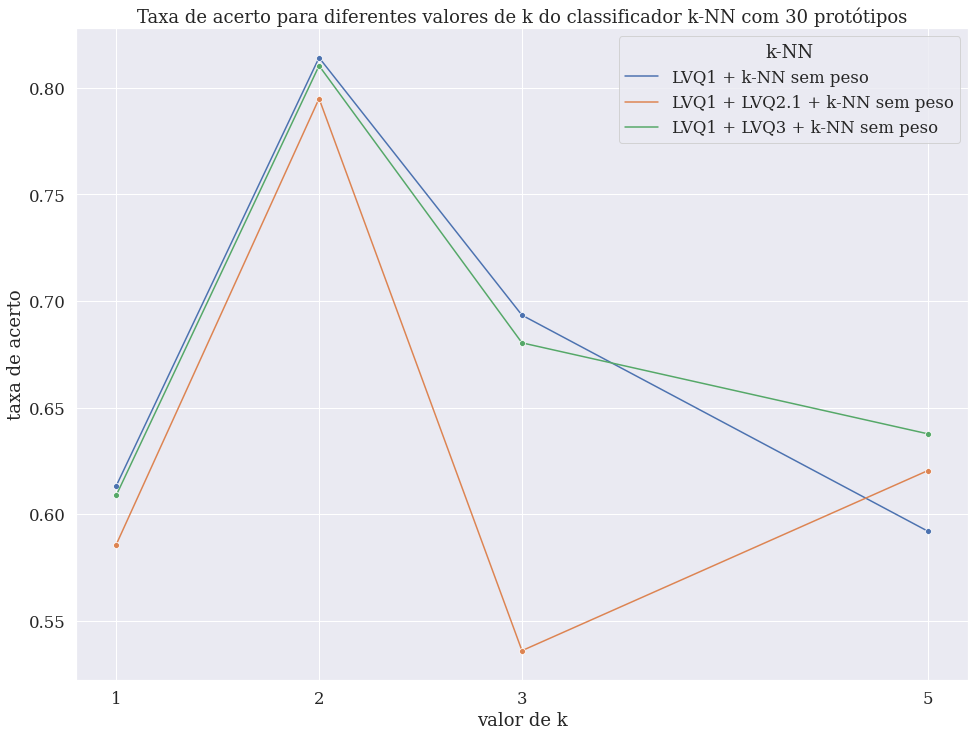

In [ ]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("darkgrid")
sns.set(font="DeJavu Serif",font_scale=1.5)
g = sns.lineplot(data=df, x="valor de k", y="taxa de acerto",marker='o',hue="k-NN")
g.set_xticks(k_list) # <--- set the ticks first
plt.title('Taxa de acerto para diferentes valores de k do classificador k-NN com ' + str(n) + ' protótipos')
plt.grid(True)  #just add this
plt.show()

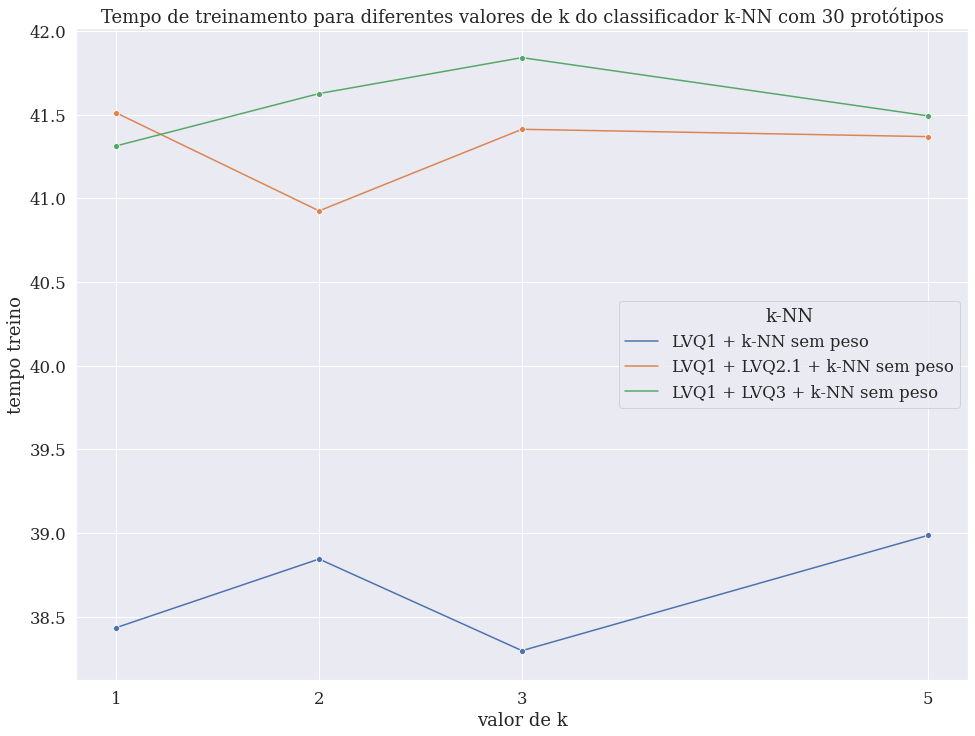

In [ ]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("darkgrid")
sns.set(font="DeJavu Serif",font_scale=1.5)
g = sns.lineplot(data=df, x="valor de k", y="tempo treino",marker='o',hue="k-NN")
g.set_xticks(k_list) # <--- set the ticks first
plt.title('Tempo de treinamento para diferentes valores de k do classificador k-NN com ' + str(n) + ' protótipos')
plt.grid(True)  #just add this
plt.show()

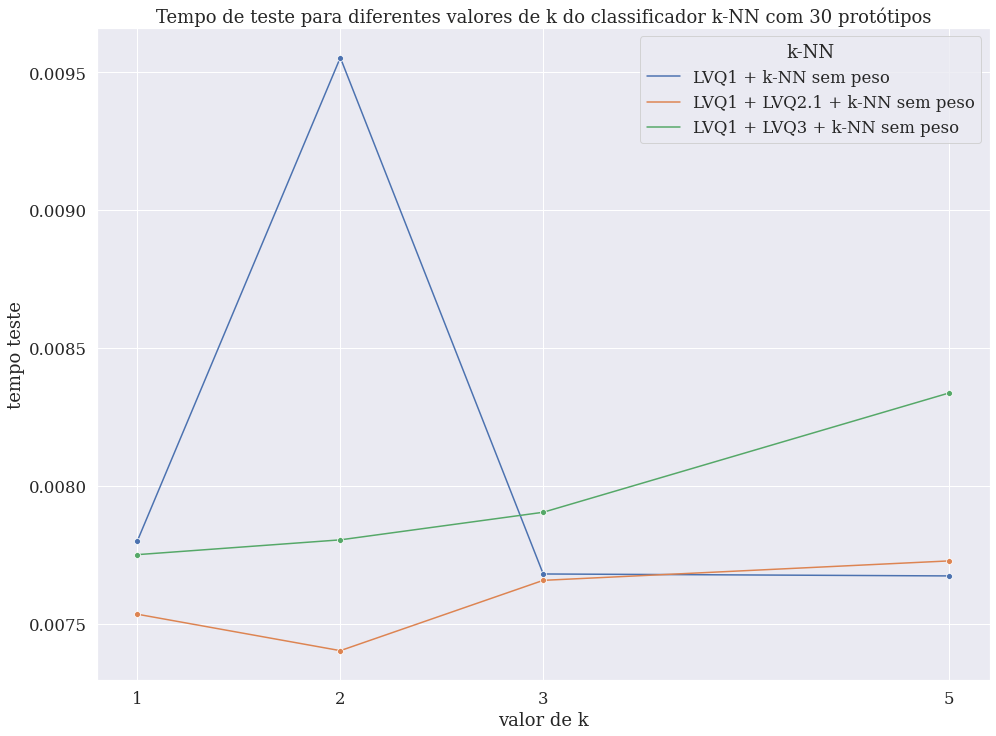

In [ ]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("darkgrid")
sns.set(font="DeJavu Serif",font_scale=1.5)
g = sns.lineplot(data=df, x="valor de k", y="tempo teste",marker='o',hue="k-NN")
g.set_xticks(k_list) # <--- set the ticks first
plt.title('Tempo de teste para diferentes valores de k do classificador k-NN com ' + str(n) + ' protótipos')
plt.grid(True)  #just add this
plt.show()